In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import BatchNormalization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

2023-08-24 14:08:30.833728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 14:08:30.991330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-24 14:08:30.991350: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-24 14:08:31.024816: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-24 14:08:31.855111: W tensorflow/stream_executor/platform/de

In [2]:
path = 'data/preprocessed'
file_name = 'preproc'

df = pd.read_csv(f'../{path}/{file_name}.csv')

df.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week,utc_offset
0,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0
1,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0
2,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0
3,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0
4,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0


In [3]:
df.shape

(553855, 20)

## Keep small sample

In [4]:
sample_size = 75000 

start_index = 0  

# Create a smaller sequential subset
data = df.iloc[start_index:start_index+sample_size]

data.shape

(75000, 20)

In [5]:
data['is_fishing'].value_counts()

is_fishing
0.0    57472
1.0    17528
Name: count, dtype: int64

### Export small dataset

In [6]:
output_folder = '../data/preprocessed'
output_file = f'preproc_{int(sample_size/1000)}k.csv'

# Construct the full path
output_path = f'{output_folder}/{output_file}'

# Save the DataFrame to the specified path
data.to_csv(output_path, index=False)

# Baseline Model: KNeighborsClassifier

## Split Data

In [7]:
X = data.drop('is_fishing', axis=1)
X = X.drop('date', axis=1)
X = X.drop('utc_offset', axis=1)
y = data['is_fishing']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

X_train.head(10)

,mmsi,distance_from_shore,distance_from_port,speed,course,lat,lon,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week
0,1.252340e+12,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
1,1.252340e+12,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
2,1.252340e+12,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
3,1.252340e+12,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
4,1.252340e+12,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
5,1.252340e+12,0.0,0.0,0.0,128.0,52.458683,4.581250,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
6,1.252340e+12,0.0,0.0,0.0,128.0,52.458698,4.581200,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
7,1.252340e+12,0.0,0.0,0.0,128.0,52.458698,4.581200,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
8,1.252340e+12,0.0,0.0,0.0,128.0,52.458668,4.581267,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
9,1.252340e+12,0.0,0.0,0.0,128.0,52.458618,4.581234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3


In [8]:
X_train.shape

(52500, 17)

## Model  => Look a precision

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score

In [10]:
# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),         # Step 1: Standardize features
    ('knn', KNeighborsClassifier(n_neighbors=3))  # Step 2: K-Nearest Neighbors model
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

Accuracy: 0.67
Precision: 0.45


# Recurrent Neutal Network setup

## Data prep

In [11]:
number_vessel=data['mmsi'].value_counts().count()
print('Total number of vessels in our small dataset: ', number_vessel)

Total number of vessels in our small dataset:  27


### Split data by vessels

In [12]:
X = data.drop('date', axis=1)
X = X.drop('utc_offset', axis=1)

In [13]:
grouped = X.groupby('mmsi')

# List to store the NumPy arrays for each group
X_group_arrays = []
y_group_arrays = []

# Iterate through each group and store the data as a NumPy array
for mmsi_value, group_df in grouped:
    # 'group_df' contains the subset of data for the current 'mmsi' group
    # Convert the relevant columns to a NumPy array and append it to the list
    X_group_array = group_df.drop('is_fishing', axis=1).values
    X_group_array = group_df.drop('mmsi', axis=1).values
    X_group_arrays.append(X_group_array)
    
    y_group_array = group_df['is_fishing'].values
    y_group_arrays.append(y_group_array)
    
assert(len(X_group_arrays) == number_vessel)
assert(len(y_group_arrays) == number_vessel)


### Padding

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_pad = pad_sequences(X_group_arrays, dtype='float32', padding='post', value=-1000)
print('X_train_pad shape: ',X_pad.shape)



X_train_pad shape:  (27, 10592, 17)


In [15]:
pd.DataFrame(X_pad[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015.0,1.0,3.0
1,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015.0,1.0,3.0
2,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015.0,1.0,3.0
3,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015.0,1.0,3.0
4,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10587,-1000.0,-1000.0,-1000.0,-1000.0,-1000.000000,-1000.000000,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0
10588,-1000.0,-1000.0,-1000.0,-1000.0,-1000.000000,-1000.000000,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0
10589,-1000.0,-1000.0,-1000.0,-1000.0,-1000.000000,-1000.000000,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0
10590,-1000.0,-1000.0,-1000.0,-1000.0,-1000.000000,-1000.000000,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0


### Split train / test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_group_arrays, test_size=0.3, shuffle=False)

print(X_train.shape)
print(X_test.shape)

print()
print(len(y_train))
print(len(y_test))

(18, 10592, 17)
(9, 10592, 17)

18
9


### Convert y_train into 2D array  (None, 1)  -> None = number of total data point

In [17]:
concatenated_array = np.concatenate(y_train, axis=0)
y_train_array = np.expand_dims(concatenated_array, axis=-1)

concatenated_array = np.concatenate(y_test, axis=0)
y_test_array = np.expand_dims(concatenated_array, axis=-1)

print(y_train_array.shape)
print(y_test_array.shape)

total_data = y_train_array.shape[0] + y_test_array.shape[0]

print('total data points: ', total_data)


(48793, 1)
(26207, 1)
total data points:  75000


### Length distribution of data points per vessels

(array([7., 5., 4., 8., 1., 1., 0., 0., 0., 1.]),
 array([  171. ,  1213.1,  2255.2,  3297.3,  4339.4,  5381.5,  6423.6,
         7465.7,  8507.8,  9549.9, 10592. ]),
 <BarContainer object of 10 artists>)

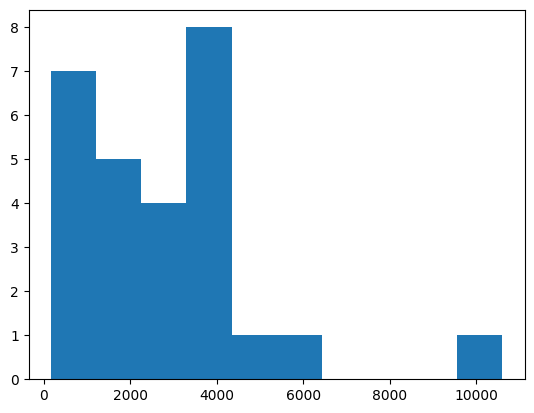

In [18]:
lengths = [len(group_array) for group_array in X_group_arrays]
plt.hist(lengths)

## init_model

In [19]:
# def init_model(input_shape):
    

    # 1 - RNN architecture
    # ======================    
    # model = models.Sequential()    
    # # Normalizing Inputs
    # # model.add(normalizer)
    
    # # Recurrent Layer
    # model.add(layers.LSTM(units=64, activation='tanh', return_sequences=False, 
    #                       recurrent_dropout=0.5, dropout=0.5, input_shape=input_shape))
    
    # # Hidden Dense Layer that we are regularizing
    # # reg_l2 = regularizers.L2(0.5)
    # # model.add(layers.Dense(32, activation="relu", kernel_regularizer = reg_l2))
    
    # model.add(layers.Dense(32, activation="relu"))
    # model.add(layers.Dropout(rate=0.5))
    
    # # Predictive Dense Layer
    # ### model.add(layers.Dense(1, activation='linear'))  
    
    # model.add(layers.Dense(1, activation='sigmoid'))
    
    # # model.build(input_shape=(None, input_shape)) 
 

    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

    # return model

In [20]:
def init_model(X_train):
    model = models.Sequential() 
    
    model.add(
        layers.Masking(
            mask_value=-1000, 
            input_shape=(X_train.shape[1], X_train.shape[2])
                       )
        )
    
    model.add(BatchNormalization()) 
    
    model.add(layers.LSTM(64, activation='tanh'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    initial_learning_rate = 0.1
    optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metrics.Precision(), metrics.Accuracy()])
    
    return model

# Model test and tuning

In [21]:
input_shape = (X_train.shape[1], X_train.shape[2])
input_shape

(10592, 17)

In [22]:
model = init_model(X_train)
model.summary()

2023-08-24 14:08:39.192255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-24 14:08:39.192396: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-24 14:08:39.192467: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Philippe-Flex): /proc/driver/nvidia/version does not exist
2023-08-24 14:08:39.193294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 10592, 17)         0         
                                                                 
 batch_normalization (BatchN  (None, 10592, 17)        68        
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 64)                20992     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 21,125
Trainable params: 21,091
Non-trainable params: 34
_________________________________________________________________


In [23]:
np.unique(y_train_array)

array([0., 1.])

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


es = EarlyStopping(monitor="val_loss",
                    patience=4,
                    mode="min",
                    restore_best_weights=True)

# Create ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # Monitor validation loss
    factor=0.5,            # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2,            # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,           # Lower bound on the learning rate
    verbose=1
)

history = model.fit(
    X_train,
    y_train_array,
    validation_split=0.3,
    shuffle=False,
    batch_size=24,
    epochs=20,
    callbacks=[es], #, reduce_lr],   # Add both callbacks to the list
    verbose=1
)

Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 5.2821e-07 - precision: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 2.4814e-06 - val_precision: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 22s 22s/step - loss: 5.2821e-07 - precision: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 2.4663e-06 - val_precision: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 23s 23s/step - loss: 5.2821e-07 - precision: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 2.4519e-06 - val_precision: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 25s 25s/step - loss: 5.2821e-07 - precision: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 2.4382e-06 - val_precision: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 23s 23s/step - loss: 5.2821e-07 - precision: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 2.4251e-06 - val_precision: 0.0

## Plot history

In [27]:
def plot_history(history, metric):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: binary_crossentropy --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('binary_crossentropy')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:accuracy ---
    
    ax[1].plot(history.history[metric])
    ax[1].plot(history.history['val_'+metric])
    ax[1].set_title(metric)
    ax[1].set_ylabel(metric)
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [28]:
history.history.keys()

dict_keys(['loss', 'precision', 'accuracy', 'val_loss', 'val_precision', 'val_accuracy'])

array([<Axes: title={'center': 'binary_crossentropy'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'precision'}, xlabel='Epoch', ylabel='precision'>],
      dtype=object)

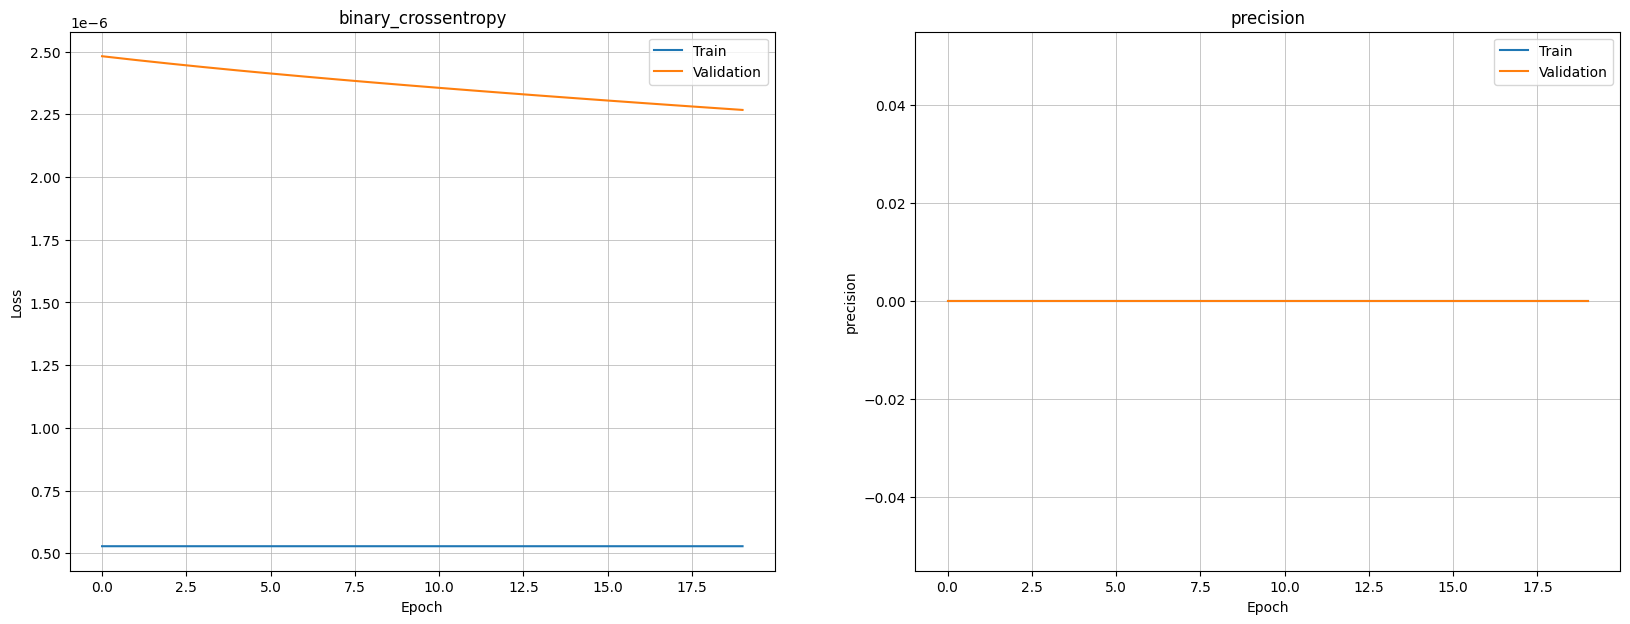

In [30]:
plot_history(history, 'precision')